In [1]:
import wntr             # For EPANET file reading
import numpy as np      
import pandas as pd
import re
import math
import pathlib 
import matplotlib as mpl
import matplotlib.pyplot as plt


font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams["mathtext.fontset"]="dejavuserif"

In [2]:
 # Replace with appropriate path and filename
directory=pathlib.Path("../../Networks/Modena")
filename=pathlib.Path("Modena_12hr.inp")
name_only=filename.stem
print("Selected File: ",name_only)
abs_path=directory/filename

Selected File:  Modena_12hr


In [3]:
demand_nodes=[]       # For storing list of nodes that have non-zero demands
base_demands=[]       # For storing demand rates desired by each node for desired volume calculations
elevations=[]         # For storing elevations of demand nodes
coords=dict()         # For storing coordinates corresponding to each node as a tuple with the id as key
all_nodes=[]          # For storing list of node ids of all nodes
all_elevations=[]     # For storing elevations of all nodes

# Creates a network model object using EPANET .inp file
network=wntr.network.WaterNetworkModel(abs_path)

# Iterates over the junction list in the Network object
for node in network.junctions():
    all_nodes.append(node[1].name)
    all_elevations.append(node[1].elevation)
    coords[node[1].name]=node[1].coordinates
    # For all nodes that have non-zero demands
    if node[1].base_demand != 0:
        # Record node ID (name), desired demand (base_demand) in CMS, elevations, x and y coordinates
        demand_nodes.append(node[1].name)
        base_demands.append(node[1].base_demand)
        elevations.append(node[1].elevation)
        

conduit_ids= []       # To store IDs of the original pipes in the EPANET file
conduit_from= []      # To store the origin node for each pipe
conduit_to= []        # To store the destination node for each pipe
conduit_lengths= []   # To store pipe lengths
conduit_diameters= [] # To store pipe diameters

# Loop over each link in the EPANET model
for link in network.pipes():

    # Extract and store each of the aforementioned properties
    conduit_ids.append(link[1].name)
    conduit_from.append(link[1].start_node_name)
    conduit_to.append(link[1].end_node_name)
    conduit_lengths.append(link[1].length)
    conduit_diameters.append(link[1].diameter)

reservoir_ids=[]      # To store the source reservoirs' IDs
reservoir_heads={}    # To store the total head of each reservoir indexed by ID
reservoir_coords={}   # To store the coordinates as tuple (x,y) indexed by ID

# Loops over each reservoir
for reservoir in network.reservoirs():
    reservoir_ids.append(reservoir[1].name)
    reservoir_heads[reservoir_ids[-1]]=reservoir[1].base_head
    reservoir_coords[reservoir_ids[-1]]=reservoir[1].coordinates
reservoir_elevations={reservoir:reservoir_heads[reservoir]-30 for reservoir in reservoir_heads}

In [4]:
# Dataframe aggregating all node information gathered from the EPANET file
junctions=pd.DataFrame(zip(all_nodes,all_elevations,coords.values()),columns=["ID","Elevation","Coordinates"])
# Set the junction ID as the index of the Dataframe
junctions.set_index("ID",inplace=True)

# Dataframe aggregating all conduit information gathered from the EPANET file
conduits=pd.DataFrame(zip(conduit_ids,conduit_from,conduit_to,conduit_lengths,conduit_diameters),columns=["ID","from node","to node","Length","diameter"])
# Set the conduit ID as the index
conduits.set_index("ID",inplace=True)

concentric=True #If this is False, Pipes will be matched using inverts

connectivity=pd.DataFrame(index=junctions.index, columns=["US","DS"])

if concentric:
    # For each node in the network
    for junction in junctions.index:
        upst_connected=[] #List of pipes whose upstream end connects to this node
        downst_connected=[] #List of pipes whose downstream end connects to this node
        # Loop over all conduits
        for conduit in conduits.index:
            # if conduit starts at this node
            if conduits.at[conduit,"from node"]==junction:
                # append to upstream connected list
                upst_connected.append(conduit)
            # if conduit ends at this node
            elif conduits.at[conduit,"to node"]==junction:
                # append to downstream connected list
                downst_connected.append(conduit)
        # create a list of all connected conduits
        connected_conduits=upst_connected+downst_connected
        # Get the diameter of all connected conduits
        connected_diameters=[conduits.at[conduit,"diameter"] for conduit in connected_conduits]
        # Find the diameter of the biggest pipe connected to this node
        max_diameter=max(connected_diameters)

        for conduit in upst_connected:
            # If pipe is not the biggest pipe
            if conduits.at[conduit,"diameter"]<max_diameter:
                # offset this pipe by half the difference in their diameters
                conduits.at[conduit,"InOffset"]=(max_diameter-conduits.at[conduit,"diameter"])/2
            # if it is the biggest pipe do nothing
            else: conduits.at[conduit,"InOffset"]=0

        for conduit in downst_connected:
            # if not the biggest connected pipe to this node
            if conduits.at[conduit,"diameter"]<max_diameter:
                # offset this pipe by half the difference in their diameters
                conduits.at[conduit,"OutOffset"]=(max_diameter-conduits.at[conduit,"diameter"])/2
            else: conduits.at[conduit,"OutOffset"]=0
    
        connectivity.at[junction,"US"]=upst_connected
        connectivity.at[junction,"DS"]=downst_connected
        connectivity.at[junction,"Max D"]=max_diameter

In [5]:
# For Spatial Discretization
maximum_xdelta_s = [250,100,50,10]         # Maximum spatial discretization in x direction
original_conduits = conduits.copy()        # Copy of original conduits dataframe
original_junctions = junctions.copy()      # Copy of original junctions dataframe

In [6]:
def discretize_pipes(maximum_xdelta):

    reservoir_pipes=[]
    conduits = original_conduits.copy()
    junctions = original_junctions.copy()

    # Loop over each conduit in the original file
    for conduit in conduits.index:

        length=conduits["Length"][conduit]  #Stores the length of the current conduit for shorthand
        n_parts = math.ceil(length / maximum_xdelta)

        xdelta = length / n_parts

        # If the conduit is bigger than the maximum allowable length (delta x), we will break it down into smaller pipes
        if n_parts>0:
            # Calculate the length of each part 
            part_length=length/n_parts
            # Start node ID (for shorthand)
            start_node=conduits["from node"][conduit]
            # Inlet Offset for the Current Conduit
            in_offset=conduits["InOffset"][conduit]
            # End node ID (for shorthand)
            end_node=conduits["to node"][conduit]
            #Outlet Offset for the Current Conduit
            out_offset=conduits["OutOffset"][conduit]
            # If the start node is a reservoir
            if start_node in reservoir_ids:
                # MAke the start elevation the same as the end but add 1 (since reservoirs don't have ground elevation in EPANET)
                start_elevation=junctions.at[end_node,"Elevation"]+1
                reservoir_elevations[start_node]=start_elevation+1
            # Otherwise make the start elevation equal to the elevation of the start node + the offset of the pipe
            else: start_elevation=junctions.at[start_node,"Elevation"]+in_offset
            
            # If the end node is a reservoir
            if end_node in reservoir_ids:
                # Make the end elevation the same as the start but subtract 1 (since reservoirs don't have ground elevation in EPANET)
                end_elevation=start_elevation-1
            # Make the end elevation equal to the elevation of the end node + the offset of the pipe
            else: end_elevation=junctions.at[end_node,"Elevation"]+out_offset
            # Calculate the uniform drop (or rise) in elevation for all the intermediate nodes about to be created when this pipe is broken into several smaller ones
            unit_elev_diff=(end_elevation-start_elevation)/n_parts

            # if the starting node is a reservoir
            if start_node in reservoir_ids:
                # Get coordinates from reservoir data
                start_x=reservoir_coords[start_node][0]
                start_y=reservoir_coords[start_node][1]
            else:
                # Get the coordinates from the junction data
                start_x=junctions.at[start_node,"Coordinates"][0]
                start_y=junctions.at[start_node,"Coordinates"][1]
            
            # If the end node is a reservoir
            if end_node in reservoir_ids:
                # Get the coordinates from the reservoir data
                end_x=reservoir_coords[end_node][0]
                end_y=reservoir_coords[end_node][1]
            else:
                # Get them from the junctions data
                end_x=junctions.at[end_node,"Coordinates"][0]
                end_y=junctions.at[end_node,"Coordinates"][1]
                
            # Calculate the unit difference in x and y coordinates for this pipe and its segments
            unit_x_diff=(end_x-start_x)/n_parts
            unit_y_diff=(end_y-start_y)/n_parts


    # THIS LOOP GENERATES THE SMALLER PIPES TO REPLACE THE ORIGINAL LONG PIPE
            # For each part to be created
            for part in np.arange(1,n_parts+1):

                # CREATING THE LINKS
                # Create the ID for the new smaller pipe as OriginPipeID-PartNumber
                new_id=conduit+"-"+str(part)
                # Set the new pipe's diameter equal to the original one
                conduits.at[new_id,"diameter"]=conduits["diameter"][conduit]
                # Set the start node as OriginStartNode-NewNodeNumber-OriginEndNode  as in the first intermediate nodes between node 13 and 14 will be named 13-1-14
                conduits.at[new_id,"from node"]=start_node+"-"+str(part-1)+"-"+end_node

                # Set Inlet and Outlet Offsets to Zero by default
                conduits.at[new_id,"InOffset"]=0
                conduits.at[new_id,"OutOffset"]=0

                # if this is the first part, use the original start node 
                if part==1:
                    conduits.at[new_id,"from node"]=start_node
                    # Set the first inlet offset to concentrically match the upstream pipe
                    conduits.at[new_id,"InOffset"]=in_offset
                    
                # Set the end node as OriginStartNode-NewNodeNumber+1-OriginEndNode  as in the second intermediate nodes between node 13 and 14 will be named 13-2-14
                conduits.at[new_id,"to node"]=start_node+"-"+str(part)+"-"+end_node
                # If this is the last part, use the original end node as the end node
                if part==n_parts:
                    conduits.at[new_id,"to node"]=end_node
                    # Set the last outlet offset to concentrically match the downstream pipe
                    conduits.at[new_id,"OutOffset"]=out_offset
                # Set the new pipe's length to the length of each part
                conduits.at[new_id,"Length"]=part_length

                # if this is NOT the last part (as the last pipe segment joins a pre-existing node and does not need a node to be created)
                if part<n_parts:
                    # Create a new node at the end of this pipe segment whose elevation is translated from the start elevation using the unit slope and the part number
                    junctions.at[conduits.at[new_id,"to node"],"Elevation"]=start_elevation+part*unit_elev_diff
                    # Calculate the coordinates for the new node using the unit difference in x and y coordinates
                    junctions.at[conduits.at[new_id,"to node"],"Coordinates"]=(start_x+part*unit_x_diff,start_y+part*unit_y_diff)

                if conduits.at[new_id,"from node"] in reservoir_ids or conduits.at[new_id,"to node"] in reservoir_ids:
                    reservoir_pipes.append(new_id)
                
            # After writing the new smaller pipes, delete the original pipe (since it is now redundant)
            conduits.drop(conduit,inplace=True)
    print(junctions.tail(5))

    return conduits, junctions

conduits_list = [original_conduits]
junctions_list = [original_junctions]
for xdelta in maximum_xdelta_s:
    conduits, junctions = discretize_pipes(xdelta)
    conduits_list.append(conduits)
    junctions_list.append(junctions)


         Elevation         Coordinates
ID                                    
46-1-50    33.7400  (4093.31, 3816.25)
50-1-51    33.1475  (4369.25, 3863.75)
271-1-1    40.2400  (539.59, 2005.125)
271-2-1    39.9900   (515.31, 2060.75)
271-3-1    39.7400  (491.03, 2116.375)
         Elevation         Coordinates
ID                                    
271-5-1      39.99   (515.31, 2060.75)
271-6-1      39.89   (505.598, 2083.0)
271-7-1      39.79  (495.886, 2105.25)
271-8-1      39.69   (486.174, 2127.5)
271-9-1      39.59  (476.462, 2149.75)
          Elevation          Coordinates
ID                                      
271-15-1      39.74   (491.03, 2116.375)
271-16-1      39.69    (486.174, 2127.5)
271-17-1      39.64  (481.318, 2138.625)
271-18-1      39.59   (476.462, 2149.75)
271-19-1      39.54  (471.606, 2160.875)
          Elevation           Coordinates
ID                                       
271-95-1      39.54   (471.606, 2160.875)
271-96-1      39.53    (470.6348, 2163.1)

In [7]:
original_conduits["Volume"] = original_conduits["Length"]*np.pi*(original_conduits["diameter"]/2)**2
pipe_volume = original_conduits["Volume"].sum()
conduits.head()

,from node,to node,Length,diameter,InOffset,OutOffset
ID,,,,,,
1-1,1,1-1-16,9.368,0.125,0.0625,0.0
1-2,1-1-16,1-2-16,9.368,0.125,0.0000,0.0
1-3,1-2-16,1-3-16,9.368,0.125,0.0000,0.0
1-4,1-3-16,1-4-16,9.368,0.125,0.0000,0.0
1-5,1-4-16,16,9.368,0.125,0.0000,0.0


In [8]:
assumed_pressure = 10 #m
A_min = np.logspace(-6,0,100)
volume_ratios = pd.DataFrame()
number_of_junctions = []
disc_lengths = ["Original", "250 m", "100 m", "50 m", "10 m"]

for junctions in junctions_list:
    number_of_junctions.append(len(junctions["Elevation"]))

number_of_junctions = {disc_lengths[i]:number_of_junctions[i] for i in range(len(disc_lengths))}
print(number_of_junctions)

{'Original': 266, '250 m': 408, '100 m': 829, '50 m': 1542, '10 m': 7290}


In [9]:
v_ratio = pd.DataFrame(columns=disc_lengths, index=A_min)
for key in number_of_junctions.keys():
    for A in A_min:
        v_ratio.at[A,key] = A*number_of_junctions[key] * assumed_pressure/pipe_volume

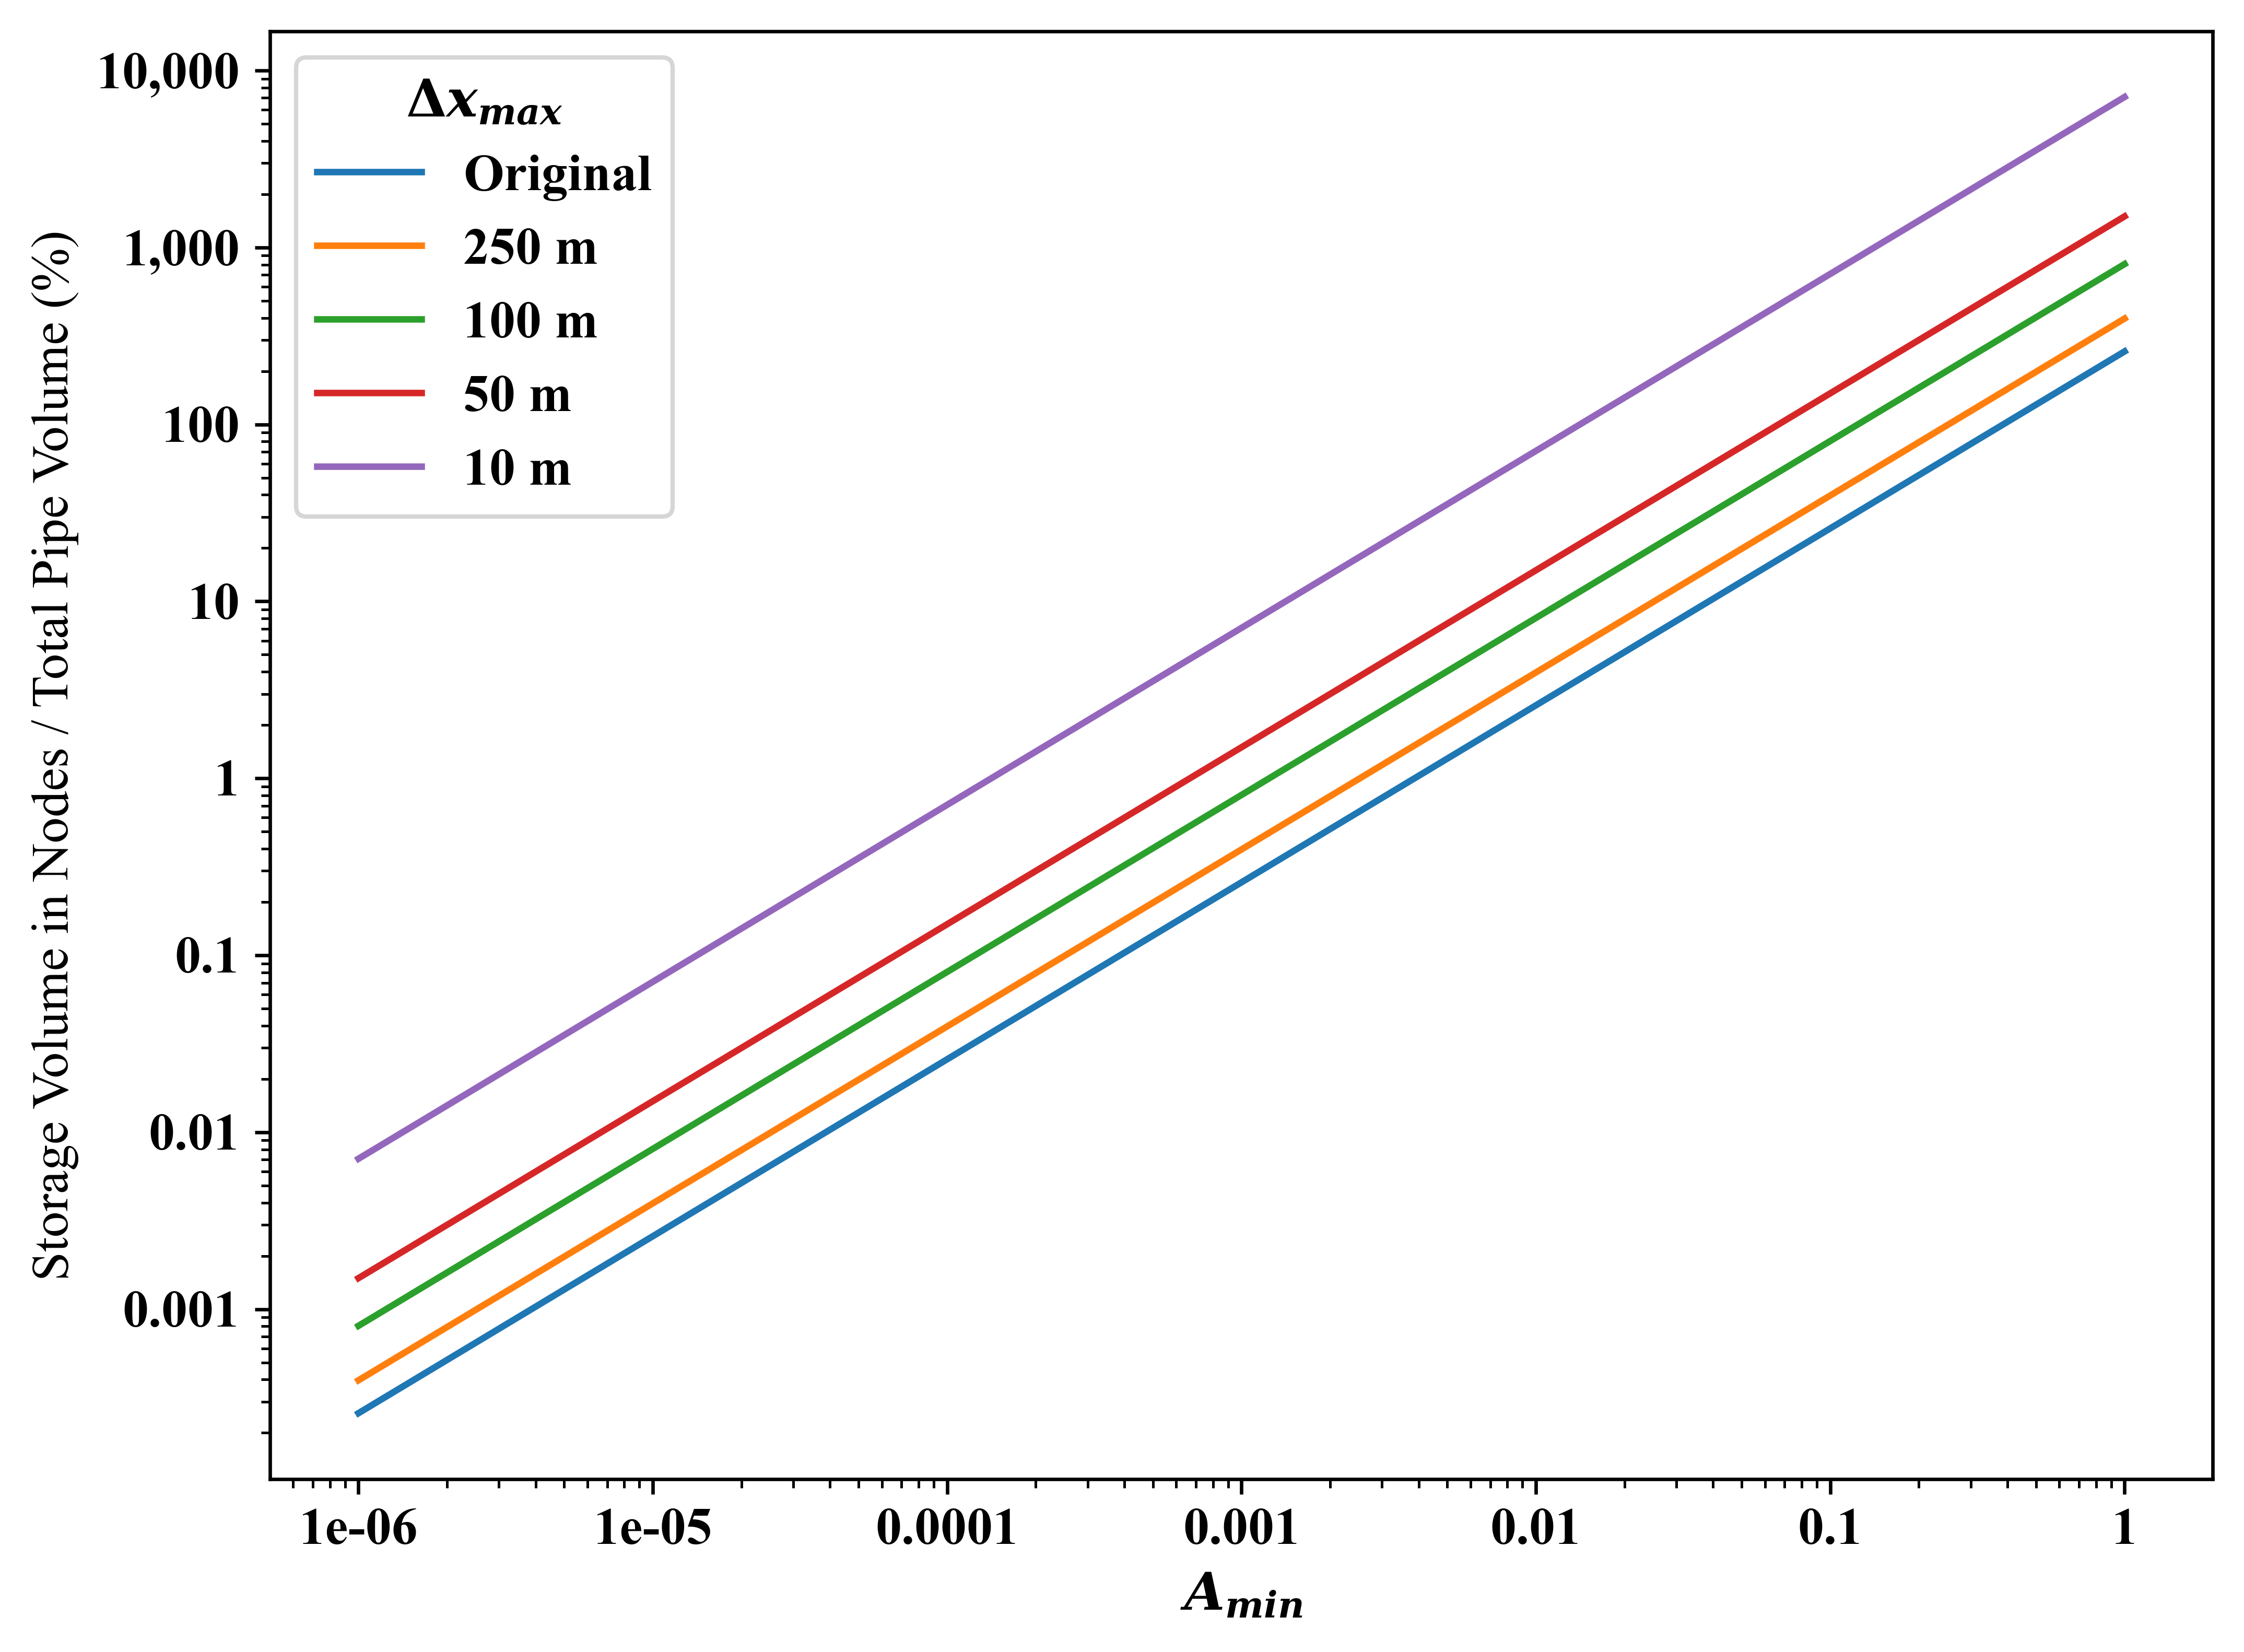

In [10]:
fig,ax = plt.subplots(figsize=(8,6))
for column in v_ratio.columns:
    ax.plot(v_ratio[column]*100,label=column)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$A_{min}$')
ax.set_ylabel('Storage Volume in Nodes / Total Pipe Volume (%)')
ax.set_yticks([0.001,0.01,0.1,1,10,100,1000,10000])
ax.set_yticklabels([0.001,0.01,0.1,1,10,100,"1,000","10,000"])
ax.set_xticks([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
ax.set_xticklabels([10**-6,1e-5,1e-4,1e-3,0.01,0.1,1])
ax.legend(title=r'$\Delta x_{max}$')
plt.savefig("../Figure Files/Figure S3 - Storage Volume Comparison.png",dpi=600, transparent=True)
plt.show()
